<a href="https://colab.research.google.com/github/DJCordhose/ai/blob/master/notebooks/tensorflow/embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Understanding Embeddings on Texts

In [0]:
# Based on
# https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.2-understanding-recurrent-neural-networks.ipynb

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [32]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [33]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.12.0


In [0]:
from tensorflow import keras

# https://keras.io/datasets/#imdb-movie-reviews-sentiment-classification
max_features = 10000  # number of words to consider as features
maxlen = 50  # cut texts after this number of words (among top max_features most common words)

# each review is encoded as a sequence of word indexes
# indexed by overall frequency in the dataset
# output is 0 (negative) or 1 (positive) 
imdb = keras.datasets.imdb.load_data(num_words=max_features)
(raw_input_train, y_train), (raw_input_test, y_test) = imdb

In [0]:
# tf.keras.datasets.imdb.load_data?

In [36]:
y_train.min()

0

In [37]:
y_train.max()

1

In [38]:
# 25000 texts
len(raw_input_train)

25000

In [39]:
# first text has 218 words
len(raw_input_train[0])

218

In [40]:
raw_input_train[0]

[1,
 14,
 22,
 16,
 43,
 530,
 973,
 1622,
 1385,
 65,
 458,
 4468,
 66,
 3941,
 4,
 173,
 36,
 256,
 5,
 25,
 100,
 43,
 838,
 112,
 50,
 670,
 2,
 9,
 35,
 480,
 284,
 5,
 150,
 4,
 172,
 112,
 167,
 2,
 336,
 385,
 39,
 4,
 172,
 4536,
 1111,
 17,
 546,
 38,
 13,
 447,
 4,
 192,
 50,
 16,
 6,
 147,
 2025,
 19,
 14,
 22,
 4,
 1920,
 4613,
 469,
 4,
 22,
 71,
 87,
 12,
 16,
 43,
 530,
 38,
 76,
 15,
 13,
 1247,
 4,
 22,
 17,
 515,
 17,
 12,
 16,
 626,
 18,
 2,
 5,
 62,
 386,
 12,
 8,
 316,
 8,
 106,
 5,
 4,
 2223,
 5244,
 16,
 480,
 66,
 3785,
 33,
 4,
 130,
 12,
 16,
 38,
 619,
 5,
 25,
 124,
 51,
 36,
 135,
 48,
 25,
 1415,
 33,
 6,
 22,
 12,
 215,
 28,
 77,
 52,
 5,
 14,
 407,
 16,
 82,
 2,
 8,
 4,
 107,
 117,
 5952,
 15,
 256,
 4,
 2,
 7,
 3766,
 5,
 723,
 36,
 71,
 43,
 530,
 476,
 26,
 400,
 317,
 46,
 7,
 4,
 2,
 1029,
 13,
 104,
 88,
 4,
 381,
 15,
 297,
 98,
 32,
 2071,
 56,
 26,
 141,
 6,
 194,
 7486,
 18,
 4,
 226,
 22,
 21,
 134,
 476,
 26,
 480,
 5,
 144,
 30,
 5535,
 18,

In [0]:
# tf.keras.preprocessing.sequence.pad_sequences?

In [0]:
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences

input_train = keras.preprocessing.sequence.pad_sequences(raw_input_train, maxlen=maxlen)
input_test = keras.preprocessing.sequence.pad_sequences(raw_input_test, maxlen=maxlen)

In [43]:
input_train.shape, input_test.shape, y_train.shape, y_test.shape

((25000, 50), (25000, 50), (25000,), (25000,))

In [44]:
# left padded with zeros
# As a convention, "0" does not stand for a specific word, but instead is used to encode any unknown word.
input_train[0]

array([2071,   56,   26,  141,    6,  194, 7486,   18,    4,  226,   22,
         21,  134,  476,   26,  480,    5,  144,   30, 5535,   18,   51,
         36,   28,  224,   92,   25,  104,    4,  226,   65,   16,   38,
       1334,   88,   12,   16,  283,    5,   16, 4472,  113,  103,   32,
         15,   16, 5345,   19,  178,   32], dtype=int32)

### Training the embedding together with the whole model is more reasonable
Alternative: use a pre-trained model, probably trained using skip-gram

In [0]:
# tf.keras.layers.Embedding?

In [46]:
from tensorflow.keras.layers import Embedding, Flatten, GlobalAveragePooling1D, Dense, Dropout

embedding_dim = 2

model = keras.Sequential()
# Parameters: max_features * embedding_dim 
model.add(Embedding(name='embedding', input_dim=max_features, output_dim=embedding_dim, input_length=maxlen))

# Output: maxlen * embedding_dim (8)
model.add(Flatten(name='flatten'))

# ALTERNATIVE
# average of all embeddings (does not preserve sequence)
# model.add(GlobalAveragePooling1D(name='average_pooling'))

# binary classifier
# model.add(Dense(name='fc', units=32, activation='relu'))
# model.add(Dropout(0.4))
model.add(Dense(name='classifier', units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 2)             20000     
_________________________________________________________________
flatten (Flatten)            (None, 100)               0         
_________________________________________________________________
classifier (Dense)           (None, 1)                 101       
Total params: 20,101
Trainable params: 20,101
Non-trainable params: 0
_________________________________________________________________


In [47]:
batch_size = 96

%time history = model.fit(input_train, y_train, epochs=40, batch_size=batch_size, validation_data=(input_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/40
25000/25000 [==============================] - 1s 36us/step - loss: 0.6879 - acc: 0.5650 - val_loss: 0.6706 - val_acc: 0.6829
Epoch 2/40
25000/25000 [==============================] - 1s 20us/step - loss: 0.5941 - acc: 0.7602 - val_loss: 0.5229 - val_acc: 0.7744
Epoch 3/40
25000/25000 [==============================] - 1s 21us/step - loss: 0.4554 - acc: 0.8132 - val_loss: 0.4410 - val_acc: 0.8046
Epoch 4/40
25000/25000 [==============================] - 1s 20us/step - loss: 0.3862 - acc: 0.8384 - val_loss: 0.4101 - val_acc: 0.8161
Epoch 5/40
25000/25000 [==============================] - 1s 21us/step - loss: 0.3471 - acc: 0.8569 - val_loss: 0.3966 - val_acc: 0.8208
Epoch 6/40
25000/25000 [==============================] - 1s 20us/step - loss: 0.3198 - acc: 0.8701 - val_loss: 0.3909 - val_acc: 0.8218
Epoch 7/40
25000/25000 [==============================] - 1s 20us/step - loss: 0.2987 - acc: 0.8788 - val_loss: 0.3906 - val_acc

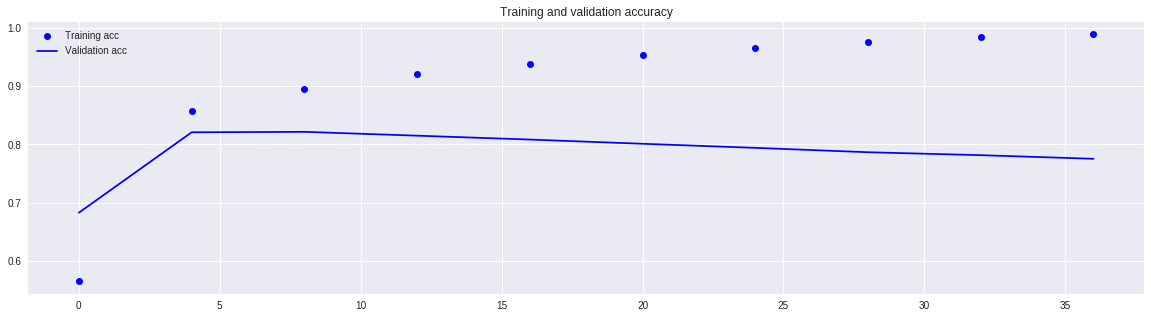

In [48]:
import pandas as pd

def plot_history(history, samples=10, init_phase_samples=None):
    epochs = history.params['epochs']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']

    every_sample =  int(epochs / samples)
    acc = pd.DataFrame(acc).iloc[::every_sample, :]
    val_acc = pd.DataFrame(val_acc).iloc[::every_sample, :]

    fig, ax = plt.subplots(figsize=(20,5))

    ax.plot(acc, 'bo', label='Training acc')
    ax.plot(val_acc, 'b', label='Validation acc')
    ax.set_title('Training and validation accuracy')
    ax.legend()

plot_history(history)

In [49]:
train_loss, train_accuracy = model.evaluate(input_train, y_train, batch_size=batch_size)
train_accuracy

25000/25000 [==============================] - 0s 8us/step


0.9943199937438965

In [50]:
test_loss, test_accuracy = model.evaluate(input_test, y_test, batch_size=batch_size)
test_accuracy

25000/25000 [==============================] - 0s 8us/step


0.7732800003242493

In [51]:
# precition
model.predict(input_test[0:5])

array([[0.80683035],
       [0.9945182 ],
       [0.4653315 ],
       [0.68047816],
       [0.99997866]], dtype=float32)

In [52]:
# ground truth
y_test[0:5]

array([0, 1, 1, 0, 1])

### How does the output of the trained embedding look like? 

In [0]:
embedding_layer = model.get_layer('embedding')

In [0]:
model_stub= keras.Model(inputs=model.input, outputs=embedding_layer.output)

In [0]:
word_to_id = keras.datasets.imdb.get_word_index()

def encode_text(text):
    input_words = text.split()
    input_tokens = np.array([word_to_id[word] for word in input_words])
    padded_input_tokens = keras.preprocessing.sequence.pad_sequences([input_tokens], maxlen=maxlen)
    return padded_input_tokens

def plot_text_embedding(model, text):
    input_words = text.split()
    input_sequence = encode_text(text)
    
    embeddings = model.predict(input_sequence)[0][-len(input_words):, :]
    x_coords = embeddings[:, 0] # First latent dim
    y_coords = embeddings[:, 1] # Second latent dim
    plt.figure(figsize=(20, 20))
    plt.scatter(x_coords, y_coords)
    for i, txt in enumerate(input_words):
        plt.annotate(txt, (x_coords[i], y_coords[i]))
    plt.show()

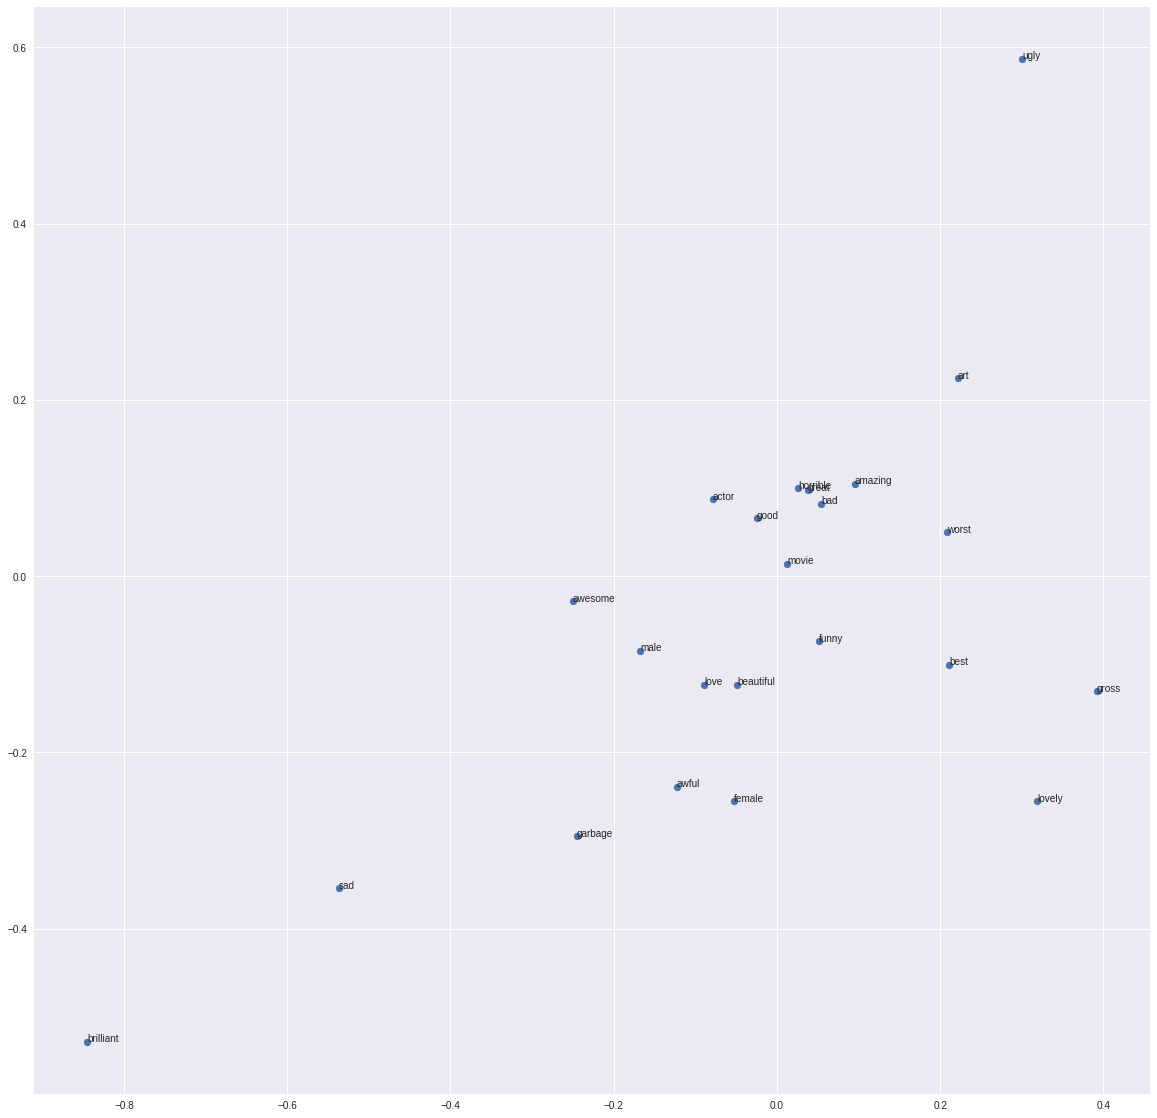

In [56]:
text = """good best brilliant amazing great lovely awesome 
          bad worst awful 
          art
          garbage gross horrible
          sad funny 
          beautiful ugly
               movie actor male female love"""
plot_text_embedding(model_stub, text)

In [57]:
from tensorflow.keras.layers import Embedding, Flatten, GlobalAveragePooling1D, Dense, Dropout

embedding_dim = 1

model = keras.Sequential()
# Parameters: max_features * embedding_dim 
model.add(Embedding(name='embedding', input_dim=max_features, output_dim=embedding_dim, input_length=maxlen))

# Output: maxlen * embedding_dim (8)
model.add(Flatten(name='flatten'))

# ALTERNATIVE
# average of all embeddings (does not preserve sequence)
# model.add(GlobalAveragePooling1D(name='average_pooling'))

# binary classifier
model.add(Dense(name='fc', units=32, activation='relu'))
# model.add(Dropout(0.4))
model.add(Dense(name='classifier', units=1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# model.summary()
batch_size = 96

%time history = model.fit(input_train, y_train, epochs=40, batch_size=batch_size, validation_data=(input_test, y_test))

Train on 25000 samples, validate on 25000 samples
Epoch 1/40
25000/25000 [==============================] - 1s 40us/step - loss: 0.6897 - acc: 0.5386 - val_loss: 0.6646 - val_acc: 0.6654
Epoch 2/40
25000/25000 [==============================] - 1s 22us/step - loss: 0.4884 - acc: 0.7833 - val_loss: 0.4087 - val_acc: 0.8124
Epoch 3/40
25000/25000 [==============================] - 1s 22us/step - loss: 0.3422 - acc: 0.8529 - val_loss: 0.3987 - val_acc: 0.8188
Epoch 4/40
25000/25000 [==============================] - 1s 22us/step - loss: 0.2953 - acc: 0.8766 - val_loss: 0.4096 - val_acc: 0.8180
Epoch 5/40
25000/25000 [==============================] - 1s 22us/step - loss: 0.2651 - acc: 0.8928 - val_loss: 0.4291 - val_acc: 0.8135
Epoch 6/40
25000/25000 [==============================] - 1s 22us/step - loss: 0.2430 - acc: 0.9044 - val_loss: 0.4544 - val_acc: 0.8089
Epoch 7/40
25000/25000 [==============================] - 1s 22us/step - loss: 0.2248 - acc: 0.9122 - val_loss: 0.4799 - val_acc

## What about 1d?

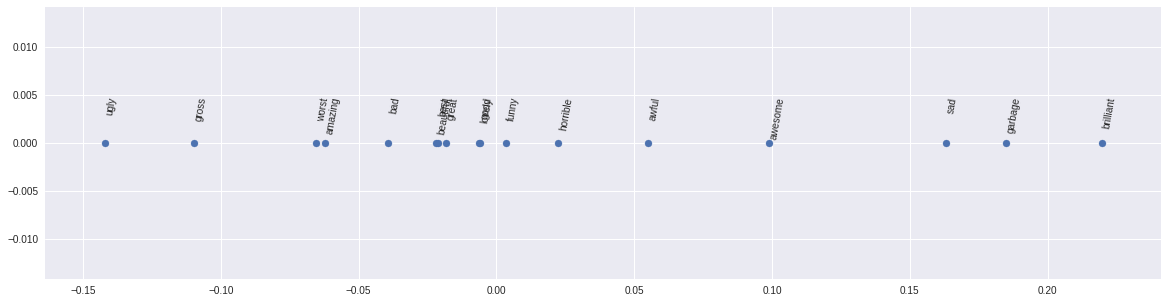

In [58]:
embedding_layer = model.get_layer('embedding')
model_stub= keras.Model(inputs=model.input, outputs=embedding_layer.output)

def plot_1d_text_embedding(model, text):
    input_words = text.split()
    input_sequence = encode_text(text)
    
    embeddings = model.predict(input_sequence)[0][-len(input_words):, :]
    plt.figure(figsize=(20, 5))
    plt.scatter(embeddings, np.zeros(len(embeddings)))
    for i, txt in enumerate(input_words):
        plt.annotate(txt, (embeddings[i], 0.004), rotation=80)
    plt.show()

text = """good best brilliant amazing great lovely awesome 
          bad worst awful 
          garbage gross horrible
          sad funny 
          beautiful ugly"""
plot_1d_text_embedding(model_stub, text)    